# Lab 13: PPO and DDPG

In this lab, we continue with policy gradient RL methods.
There are many algorithms that attempt to improve upon the ordinary Actor critic.
Today, we sample two of these: PPO and DDPG.

References for this lab:
- https://medium.com/deepgamingai/proximal-policy-optimization-tutorial-part-2-2-gae-and-ppo-loss-22337981f815
- https://github.com/alirezakazemipour/Continuous-PPO
- https://github.com/MWeltevrede/PPO
- https://github.com/alirezakazemipour/DDPG-HER
- https://sites.ualberta.ca/~pilarski/docs/papers/Pilarski_2013_ICORR_Postprint.pdf
- https://github.com/TianhongDai/hindsight-experience-replay
- https://github.com/alirezakazemipour/DDPG-HER

## Proximal Policy Optimization (PPO)

The PPO algorithm was introduced by OpenAI in 2017 and quickly surpassed DQN in popularity.
PPO collects a small batch of experiences of the agent interacting with the environment and
uses that batch to update the policy. Experiences are only used once, immediately, making the
method an on-policy method.

The key contribution of PPO is a regularization method ensuring that new updates to the policy do not change
it too much, leading to lower variance at the cost of some bias, smooth training, without any catastrophic
optimizations that lead to useless actions.

In [1]:
process_device = "cuda:1"

### The actor model

Same as normal actor model, the Actor model performs the task of learning what action to take under a particular **observed state** of the environment.

### The critic model

Also the same, we send the action predicted by the Actor to the environment and observe what happens in the game. If something positive happens as a result of our action, like agent can increase some plus point, then the environment sends back a positive response in the form of a reward. If an own goal occurs due to our action, then we get a negative reward. This reward is taken in by the **Critic model**.

In [2]:
# model.py

from torch import nn
from torch.distributions import normal
import torch


class Actor(nn.Module):

    def __init__(self, n_states, n_actions):
        super(Actor, self).__init__()
        self.n_states = n_states
        self.n_actions = n_actions

        self.fc1 = nn.Linear(in_features=self.n_states, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=64)
        self.mu = nn.Linear(in_features=64, out_features=self.n_actions)

        self.log_std = nn.Parameter(torch.zeros(1, self.n_actions))

        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.orthogonal_(layer.weight)
                layer.bias.data.zero_()

    def forward(self, inputs):
        x = inputs
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        mu = self.mu(x)

        std = self.log_std.exp()
        dist = normal.Normal(mu, std)

        return dist


class Critic(nn.Module):
    def __init__(self, n_states):
        super(Critic, self).__init__()
        self.n_states = n_states

        self.fc1 = nn.Linear(in_features=self.n_states, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=64)
        self.value = nn.Linear(in_features=64, out_features=1)

        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.orthogonal_(layer.weight)
                layer.bias.data.zero_()

    def forward(self, inputs):
        x = inputs
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        value = self.value(x)

        return value

### Agent

Agent is the AI agent core which contain the network model to use and to load, save and update any weights of the models.

In [3]:
# agent.py

# from model import Actor, Critic
from torch.optim import Adam
from torch import from_numpy
import numpy as np
import torch
from torch.optim.lr_scheduler import LambdaLR


class Agent:
    def __init__(self, env_name, n_iter, n_states, action_bounds, n_actions, lr):
        self.env_name = env_name
        self.n_iter = n_iter
        self.action_bounds = action_bounds
        self.n_actions = n_actions
        self.n_states = n_states
        self.device = torch.device(process_device)
        self.lr = lr
        
        self.current_policy = Actor(n_states=self.n_states,
                                    n_actions=self.n_actions).to(self.device)
        self.critic = Critic(n_states=self.n_states).to(self.device)

        self.actor_optimizer = Adam(self.current_policy.parameters(), lr=self.lr, eps=1e-5)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=self.lr, eps=1e-5)

        self.critic_loss = torch.nn.MSELoss()

        self.scheduler = lambda step: max(1.0 - float(step / self.n_iter), 0)

        self.actor_scheduler = LambdaLR(self.actor_optimizer, lr_lambda=self.scheduler)
        self.critic_scheduler = LambdaLR(self.actor_optimizer, lr_lambda=self.scheduler)

    def choose_dist(self, state):
        state = np.expand_dims(state, 0)
        state = from_numpy(state).float().to(self.device)
        with torch.no_grad():
            dist = self.current_policy(state)

        # action *= self.action_bounds[1]
        # action = np.clip(action, self.action_bounds[0], self.action_bounds[1])

        return dist

    def get_value(self, state):
        state = np.expand_dims(state, 0)
        state = from_numpy(state).float().to(self.device)
        with torch.no_grad():
            value = self.critic(state)

        return value.detach().cpu().numpy()

    def optimize(self, actor_loss, critic_loss):
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        # torch.nn.utils.clip_grad_norm_(self.current_policy.parameters(), 0.5)
        # torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # torch.nn.utils.clip_grad_norm_(self.current_policy.parameters(), 0.5)
        # torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
        self.critic_optimizer.step()

    def schedule_lr(self):
        # self.total_scheduler.step()
        self.actor_scheduler.step()
        self.critic_scheduler.step()

    def save_weights(self, iteration, state_rms):
        torch.save({"current_policy_state_dict": self.current_policy.state_dict(),
                    "critic_state_dict": self.critic.state_dict(),
                    "actor_optimizer_state_dict": self.actor_optimizer.state_dict(),
                    "critic_optimizer_state_dict": self.critic_optimizer.state_dict(),
                    "actor_scheduler_state_dict": self.actor_scheduler.state_dict(),
                    "critic_scheduler_state_dict": self.critic_scheduler.state_dict(),
                    "iteration": iteration,
                    "state_rms_mean": state_rms.mean,
                    "state_rms_var": state_rms.var,
                    "state_rms_count": state_rms.count}, self.env_name + "_weights.pth")

    def load_weights(self):
        checkpoint = torch.load(self.env_name + "_weights.pth")
        self.current_policy.load_state_dict(checkpoint["current_policy_state_dict"])
        self.critic.load_state_dict(checkpoint["critic_state_dict"])
        self.actor_optimizer.load_state_dict(checkpoint["actor_optimizer_state_dict"])
        self.critic_optimizer.load_state_dict(checkpoint["critic_optimizer_state_dict"])
        self.actor_scheduler.load_state_dict(checkpoint["actor_scheduler_state_dict"])
        self.critic_scheduler.load_state_dict(checkpoint["critic_scheduler_state_dict"])
        iteration = checkpoint["iteration"]
        state_rms_mean = checkpoint["state_rms_mean"]
        state_rms_var = checkpoint["state_rms_var"]

        return iteration, state_rms_mean, state_rms_var

    def set_to_eval_mode(self):
        self.current_policy.eval()
        self.critic.eval()

    def set_to_train_mode(self):
        self.current_policy.train()
        self.critic.train()

### Mean, Std

In actor critic model, to perform the stat before go to the model, it is necessary to do something like a batch normalization to the state.

In [4]:
# running_mean_std.py

import numpy as np


class RunningMeanStd(object):
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    # -> It's indeed batch normalization :D
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count)


def update_mean_var_count_from_moments(mean, var, count, batch_mean, batch_var, batch_count):
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + np.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count

### Evaluate model function

The <code>evaluate_model</code> is the function which uses while training. The actor critic model needs to finish each episode before training the output of accumulate rewards is the result to say how clever of your model.

In [5]:
# test.py

import numpy as np


def evaluate_model(agent, env, state_rms, action_bounds):
    total_rewards = 0
    s = env.reset()
    done = False
    while not done:
        s = np.clip((s - state_rms.mean) / (state_rms.var ** 0.5 + 1e-8), -5.0, 5.0)
        dist = agent.choose_dist(s)
        action = dist.sample().cpu().numpy()[0]
        # action = np.clip(action, action_bounds[0], action_bounds[1])
        next_state, reward, done, _ = env.step(action)
        # env.render()
        s = next_state
        total_rewards += reward
    # env.close()
    return total_rewards

### PPO

An important step in the PPO algorithm is to run through this entire loop with the two models for a fixed number of steps known as PPO steps. So essentially, we are interacting with our environemt for certain number of steps and collecting the states, actions, rewards, etc. which we will use for training.

### Generalized Advantage Estimation (GAE)

Advantage can be defined as a way to measure how much better off we can be by taking a particular action when we are in a particular state. We want to use the rewards that we collected at each time step and calculate how much of an advantage we were able to obtain by taking the action that we took. So if we took a good action, we want to calculate how much better off we were by taking that action, not only in the short run but also over a longer period of time. This way, even if we do not immediately score a goal in the next time step after shooting, we still look at few time steps after that action into the longer future to see if we scored a goal.

In order to calculate this, we’ll use an algorithm known as Generalized Advantage Estimation or GAE. So let’s take a look at how this algorithm works.

1. Initialize advantage: $gae=0$
2. Loop backwards: $t=stop$ to $t=0$
3. Define delta: $\delta=r_t+\gamma \cdot V(s_{t+1}) \cdot m_t - V(s_t)$
4. Update value of gae: $gae_t=\delta + \gamma \cdot \lambda \cdot m_t \cdot gae_{t+1}$
5. Calculate returns R: $R_t(s_t,a_t)=gae_t+V(s_t)$
6. Loop from number 2

Given:
- $m$: a mask value is used because if the game is over then the next state in our batch will be from a newly restarted game so we do not want to consider that and therefore mask value is taken as 0.
- $\gamma$: discount factor in order to reduce the value of the future state (default 0.99)
- $\lambda$: is a smoothing parameter used for reducing the variance in training which makes it more stable. (default 0.95)

### Custom PPO loss

This is the most important part of the Proximal Policy Optimization algorithm. So let’s first understand this loss function.

Recall that $\pi$ indicates the policy that is defined by our Actor neural network model. By training this model, we want to improve this policy so that it gives us better and better actions over time. Now a major problem in some Reinforcement Learning approaches is that once our model adopts a bad policy, it only takes bad actions in the game, so we are unable to generate any good actions from there on leading us down an unrecoverable path in training. PPO tries to address this by only making small updates to the model in an update step, thereby stabilizing the training process. The PPO loss can be calculated as follows.

1. Calulate how much the policy has changed: $ratio = \pi_{new}/ \pi_{old}$
2. Express in log form: $ratio = [\log (\pi_{new}) - \log(\pi_{old})].exp()$
3. Calculate Actor loss as minimum of two functions:
$$p_1 = ratio \cdot advantage$$
$$p_2 = clip(ratio, 1-\epsilon, 1+\epsilon) \cdot advantage$$ where $\epsilon=0.2$ (for example)
$$actor_{loss}=min(p_1,p_2)$$
4. Calculate Critic loss as MSE between returns and critic value: $critic_{loss}=(R-V(s))^2$
5. Calculate Total loss: $total_{loss}=critic_{loss} \cdot critic_{discount} + actor_loss \cdot entropy$

In [6]:
# train.py

import torch
import numpy as np
import time
# from running_mean_std import RunningMeanStd
# from test import evaluate_model
from torch.utils.tensorboard import SummaryWriter


class Train:
    def __init__(self, env, test_env, env_name, n_iterations, agent, epochs, mini_batch_size, epsilon, horizon):
        self.env = env
        self.env_name = env_name
        self.test_env = test_env
        self.agent = agent
        self.epsilon = epsilon
        self.horizon = horizon
        self.epochs = epochs
        self.mini_batch_size = mini_batch_size
        self.n_iterations = n_iterations

        self.start_time = 0
        self.state_rms = RunningMeanStd(shape=(self.agent.n_states,))

        self.running_reward = 0

    @staticmethod
    def choose_mini_batch(mini_batch_size, states, actions, returns, advs, values, log_probs):
        full_batch_size = len(states)
        for _ in range(full_batch_size // mini_batch_size):
            indices = np.random.randint(0, full_batch_size, mini_batch_size)
            yield states[indices], actions[indices], returns[indices], advs[indices], values[indices],\
                  log_probs[indices]

    def train(self, states, actions, advs, values, log_probs):

        values = np.vstack(values[:-1])
        log_probs = np.vstack(log_probs)
        returns = advs + values
        advs = (advs - advs.mean()) / (advs.std() + 1e-8)
        actions = np.vstack(actions)
        for epoch in range(self.epochs):
            for state, action, return_, adv, old_value, old_log_prob in self.choose_mini_batch(self.mini_batch_size,
                                                                                               states, actions, returns,
                                                                                               advs, values, log_probs):
                state = torch.Tensor(state).to(self.agent.device)
                action = torch.Tensor(action).to(self.agent.device)
                return_ = torch.Tensor(return_).to(self.agent.device)
                adv = torch.Tensor(adv).to(self.agent.device)
                old_value = torch.Tensor(old_value).to(self.agent.device)
                old_log_prob = torch.Tensor(old_log_prob).to(self.agent.device)

                value = self.agent.critic(state)
                # clipped_value = old_value + torch.clamp(value - old_value, -self.epsilon, self.epsilon)
                # clipped_v_loss = (clipped_value - return_).pow(2)
                # unclipped_v_loss = (value - return_).pow(2)
                # critic_loss = 0.5 * torch.max(clipped_v_loss, unclipped_v_loss).mean()
                critic_loss = self.agent.critic_loss(value, return_)

                new_log_prob = self.calculate_log_probs(self.agent.current_policy, state, action)

                ratio = (new_log_prob - old_log_prob).exp()
                actor_loss = self.compute_actor_loss(ratio, adv)

                self.agent.optimize(actor_loss, critic_loss)

        return actor_loss, critic_loss

    def step(self):
        state = self.env.reset()
        for iteration in range(1, 1 + self.n_iterations):
            states = []
            actions = []
            rewards = []
            values = []
            log_probs = []
            dones = []

            self.start_time = time.time()
            for t in range(self.horizon):
                # self.state_rms.update(state)
                state = np.clip((state - self.state_rms.mean) / (self.state_rms.var ** 0.5 + 1e-8), -5, 5)
                dist = self.agent.choose_dist(state)
                action = dist.sample()
                # action = np.clip(action, self.agent.action_bounds[0], self.agent.action_bounds[1])
                log_prob = dist.log_prob(action).cpu()
                action = action.cpu().numpy()[0]
                value = self.agent.get_value(state)
                next_state, reward, done, _ = self.env.step(action)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                values.append(value)
                log_probs.append(log_prob)
                dones.append(done)

                if done:
                    state = self.env.reset()
                else:
                    state = next_state
            # self.state_rms.update(next_state)
            next_state = np.clip((next_state - self.state_rms.mean) / (self.state_rms.var ** 0.5 + 1e-8), -5, 5)
            next_value = self.agent.get_value(next_state) * (1 - done)
            values.append(next_value)

            advs = self.get_gae(rewards, values, dones)
            states = np.vstack(states)
            actor_loss, critic_loss = self.train(states, actions, advs, values, log_probs)
            # self.agent.set_weights()
            self.agent.schedule_lr()
            eval_rewards = evaluate_model(self.agent, self.test_env, self.state_rms, self.agent.action_bounds)
            self.state_rms.update(states)
            self.print_logs(iteration, actor_loss, critic_loss, eval_rewards)
            print("iteration: ", iteration, "\teval_rewards: ", eval_rewards)

    @staticmethod
    def get_gae(rewards, values, dones, gamma=0.99, lam=0.95):

        advs = []
        gae = 0

        dones.append(0)
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + gamma * (values[step + 1]) * (1 - dones[step]) - values[step]
            gae = delta + gamma * lam * (1 - dones[step]) * gae
            advs.append(gae)

        advs.reverse()
        return np.vstack(advs)

    @staticmethod
    def calculate_log_probs(model, states, actions):
        policy_distribution = model(states)
        return policy_distribution.log_prob(actions)

    def compute_actor_loss(self, ratio, adv):
        pg_loss1 = adv * ratio
        pg_loss2 = adv * torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon)
        loss = -torch.min(pg_loss1, pg_loss2).mean()
        return loss

    def print_logs(self, iteration, actor_loss, critic_loss, eval_rewards):
        if iteration == 1:
            self.running_reward = eval_rewards
        else:
            self.running_reward = self.running_reward * 0.99 + eval_rewards * 0.01

        if iteration % 100 == 0:
            print(f"Iter:{iteration}| "
                  f"Ep_Reward:{eval_rewards:.3f}| "
                  f"Running_reward:{self.running_reward:.3f}| "
                  f"Actor_Loss:{actor_loss:.3f}| "
                  f"Critic_Loss:{critic_loss:.3f}| "
                  f"Iter_duration:{time.time() - self.start_time:.3f}| "
                  f"lr:{self.agent.actor_scheduler.get_last_lr()}")
            self.agent.save_weights(iteration, self.state_rms)

        with SummaryWriter(self.env_name + "/logs") as writer:
            writer.add_scalar("Episode running reward", self.running_reward, iteration)
            writer.add_scalar("Episode reward", eval_rewards, iteration)
            writer.add_scalar("Actor loss", actor_loss, iteration)
            writer.add_scalar("Critic loss", critic_loss, iteration)

In [7]:
# play.py

from mujoco_py.generated import const
from mujoco_py import GlfwContext
import numpy as np
import cv2
GlfwContext(offscreen=True)


class Play:
    def __init__(self, env, agent, env_name, max_episode=1):
        self.env = env
        self.max_episode = max_episode
        self.agent = agent
        _, self.state_rms_mean, self.state_rms_var = self.agent.load_weights()
        self.agent.set_to_eval_mode()
        self.device = torch.device(process_device)
        self.fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.VideoWriter = cv2.VideoWriter(env_name + ".avi", self.fourcc, 50.0, (250, 250))

    def evaluate(self):

        for _ in range(self.max_episode):
            s = self.env.reset()
            episode_reward = 0
            for _ in range(self.env._max_episode_steps):
                s = np.clip((s - self.state_rms_mean) / (self.state_rms_var ** 0.5 + 1e-8), -5.0, 5.0)
                dist = self.agent.choose_dist(s)
                action = dist.sample().cpu().numpy()[0]
                s_, r, done, _ = self.env.step(action)
                episode_reward += r
                if done:
                    break
                s = s_
                # self.env.render(mode="human")
                # self.env.viewer.cam.type = const.CAMERA_FIXED
                # self.env.viewer.cam.fixedcamid = 0
                # time.sleep(0.03)
                I = self.env.render(mode='rgb_array')
                I = cv2.cvtColor(I, cv2.COLOR_RGB2BGR)
                I = cv2.resize(I, (250, 250))
                self.VideoWriter.write(I)
                # cv2.imshow("env", I)
                # cv2.waitKey(10)
            print(f"episode reward:{episode_reward:3.3f}")
        self.env.close()
        self.VideoWriter.release()
        cv2.destroyAllWindows()

Creating offscreen glfw


## Let's try some environment

In [9]:
import gym
import os
import mujoco_py
# from agent import Agent
# from train import Train
# from play import Play

### Double inverted pendulum

In [27]:
ENV_NAME = "InvertedDoublePendulum"
TRAIN_FLAG = True
test_env = gym.make(ENV_NAME + "-v2")

print(test_env.reset())

[ 0.07536218 -0.01266603  0.0984087   0.99991978  0.99514608 -0.06849933
 -0.11647428  0.04592492  0.          0.          0.        ]


In [11]:
n_states = test_env.observation_space.shape[0]
action_bounds = [test_env.action_space.low[0], test_env.action_space.high[0]]
n_actions = test_env.action_space.shape[0]

In [12]:
n_iterations = 500
lr = 3e-4
epochs = 10
clip_range = 0.2
mini_batch_size = 64
T = 2048

In [13]:
print(f"number of states:{n_states}\n"
      f"action bounds:{action_bounds}\n"
      f"number of actions:{n_actions}")

if not os.path.exists(ENV_NAME):
    os.mkdir(ENV_NAME)
    os.mkdir(ENV_NAME + "/logs")

env = gym.make(ENV_NAME + "-v2")

agent = Agent(n_states=n_states,
              n_iter=n_iterations,
              env_name=ENV_NAME,
              action_bounds=action_bounds,
              n_actions=n_actions,
              lr=lr)
if TRAIN_FLAG:
    trainer = Train(env=env,
                    test_env=test_env,
                    env_name=ENV_NAME,
                    agent=agent,
                    horizon=T,
                    n_iterations=n_iterations,
                    epochs=epochs,
                    mini_batch_size=mini_batch_size,
                    epsilon=clip_range)
    trainer.step()

player = Play(env, agent, ENV_NAME)
player.evaluate()

number of states:11
action bounds:[-1.0, 1.0]
number of actions:1
iteration:  1 	eval_rewards:  64.03977869424199
iteration:  2 	eval_rewards:  63.74281212489949
iteration:  3 	eval_rewards:  82.0762700197893
iteration:  4 	eval_rewards:  101.29183773500634
iteration:  5 	eval_rewards:  35.62218981504196
iteration:  6 	eval_rewards:  91.74456902843956
iteration:  7 	eval_rewards:  137.40959328327475
iteration:  8 	eval_rewards:  202.67234090600732
iteration:  9 	eval_rewards:  165.36867069691579
iteration:  10 	eval_rewards:  91.92686569958862
iteration:  11 	eval_rewards:  231.3105264898099
iteration:  12 	eval_rewards:  193.60033788769636
iteration:  13 	eval_rewards:  137.124092421563
iteration:  14 	eval_rewards:  192.64245312619192
iteration:  15 	eval_rewards:  82.50928230821982
iteration:  16 	eval_rewards:  211.33300091274936
iteration:  17 	eval_rewards:  72.3585688225138
iteration:  18 	eval_rewards:  146.55086380189505
iteration:  19 	eval_rewards:  202.1422349203148
iterati

### Walker 2D

In [14]:
ENV_NAME = "Walker2d"
TRAIN_FLAG = True
test_env = gym.make(ENV_NAME + "-v2")

n_iterations = 1500

n_states = test_env.observation_space.shape[0]
action_bounds = [test_env.action_space.low[0], test_env.action_space.high[0]]
n_actions = test_env.action_space.shape[0]

In [15]:
print(f"number of states:{n_states}\n"
      f"action bounds:{action_bounds}\n"
      f"number of actions:{n_actions}")

if not os.path.exists(ENV_NAME):
    os.mkdir(ENV_NAME)
    os.mkdir(ENV_NAME + "/logs")

env = gym.make(ENV_NAME + "-v2")

agent = Agent(n_states=n_states,
              n_iter=n_iterations,
              env_name=ENV_NAME,
              action_bounds=action_bounds,
              n_actions=n_actions,
              lr=lr)
if TRAIN_FLAG:
    trainer = Train(env=env,
                    test_env=test_env,
                    env_name=ENV_NAME,
                    agent=agent,
                    horizon=T,
                    n_iterations=n_iterations,
                    epochs=epochs,
                    mini_batch_size=mini_batch_size,
                    epsilon=clip_range)
    trainer.step()

player = Play(env, agent, ENV_NAME)
player.evaluate()

number of states:17
action bounds:[-1.0, 1.0]
number of actions:6
iteration:  1 	eval_rewards:  0.5474504746026824
iteration:  2 	eval_rewards:  0.6139819397717825
iteration:  3 	eval_rewards:  15.773683076676134
iteration:  4 	eval_rewards:  19.35315174005951
iteration:  5 	eval_rewards:  31.776205368983803
iteration:  6 	eval_rewards:  51.92884940344699
iteration:  7 	eval_rewards:  124.46137137369442
iteration:  8 	eval_rewards:  89.33800299587827
iteration:  9 	eval_rewards:  37.98785101513507
iteration:  10 	eval_rewards:  57.80770145720188
iteration:  11 	eval_rewards:  398.0232305750942
iteration:  12 	eval_rewards:  219.2012841307943
iteration:  13 	eval_rewards:  316.2882735451255
iteration:  14 	eval_rewards:  91.5811223126468
iteration:  15 	eval_rewards:  59.94967645616366
iteration:  16 	eval_rewards:  316.7300725306001
iteration:  17 	eval_rewards:  482.75372123908244
iteration:  18 	eval_rewards:  307.34882314051424
iteration:  19 	eval_rewards:  331.29939983334435
itera

### Ant (4 legs animal)

In [16]:
ENV_NAME = "Ant"
TRAIN_FLAG = True
test_env = gym.make(ENV_NAME + "-v2")

n_states = test_env.observation_space.shape[0]
action_bounds = [test_env.action_space.low[0], test_env.action_space.high[0]]
n_actions = test_env.action_space.shape[0]

In [17]:
print(f"number of states:{n_states}\n"
      f"action bounds:{action_bounds}\n"
      f"number of actions:{n_actions}")

if not os.path.exists(ENV_NAME):
    os.mkdir(ENV_NAME)
    os.mkdir(ENV_NAME + "/logs")

env = gym.make(ENV_NAME + "-v2")

agent = Agent(n_states=n_states,
              n_iter=n_iterations,
              env_name=ENV_NAME,
              action_bounds=action_bounds,
              n_actions=n_actions,
              lr=lr)
if TRAIN_FLAG:
    trainer = Train(env=env,
                    test_env=test_env,
                    env_name=ENV_NAME,
                    agent=agent,
                    horizon=T,
                    n_iterations=n_iterations,
                    epochs=epochs,
                    mini_batch_size=mini_batch_size,
                    epsilon=clip_range)
    trainer.step()

player = Play(env, agent, ENV_NAME)
player.evaluate()

number of states:111
action bounds:[-1.0, 1.0]
number of actions:8
iteration:  1 	eval_rewards:  -90.52347489201367
iteration:  2 	eval_rewards:  -2952.4207652657738
iteration:  3 	eval_rewards:  -203.85554127405481
iteration:  4 	eval_rewards:  -160.10090996163487
iteration:  5 	eval_rewards:  -59.27902447112697
iteration:  6 	eval_rewards:  -36.3396315102584
iteration:  7 	eval_rewards:  -85.49083393318256
iteration:  8 	eval_rewards:  -64.82798018891248
iteration:  9 	eval_rewards:  -134.0075425316432
iteration:  10 	eval_rewards:  -124.30530081984408
iteration:  11 	eval_rewards:  -40.6603289185003
iteration:  12 	eval_rewards:  -19.222018203265144
iteration:  13 	eval_rewards:  -34.00819165785523
iteration:  14 	eval_rewards:  -54.90853348084213
iteration:  15 	eval_rewards:  -178.0133566312446
iteration:  16 	eval_rewards:  -179.0340669161161
iteration:  17 	eval_rewards:  -136.16001405883577
iteration:  18 	eval_rewards:  -13.833301570736507
iteration:  19 	eval_rewards:  -144.7

### FetchPickAndPlace

The FetchPickAndPlace has some state output which different from the other environment.
It contains dictionary of environment in the form of:
- observation: the joint degree position and speed
- desired_goal: the target position that robot need to go
- achieved_goal


In [19]:
ENV_NAME = "FetchPickAndPlace"
TRAIN_FLAG = True
test_env = gym.make(ENV_NAME + "-v1")

n_states = test_env.observation_space["observation"].shape[0]
n_achieveds = test_env.observation_space["achieved_goal"].shape[0]
n_goals = test_env.observation_space["desired_goal"].shape[0]
action_bounds = [test_env.action_space.low[0], test_env.action_space.high[0]]
n_actions = test_env.action_space.shape[0]

print(n_states)
print(n_goals)

env_dict = test_env.reset()

state = env_dict["observation"]
achieved_goal = env_dict["achieved_goal"]
desired_goal = env_dict["desired_goal"]

print(state)
print(achieved_goal)
print(desired_goal)

25
3
[ 1.34193265e+00  7.49100375e-01  5.34722720e-01  1.19599421e+00
  8.00557661e-01  4.24702091e-01 -1.45938432e-01  5.14572867e-02
 -1.10020629e-01  2.91834773e-06 -4.72661656e-08 -3.85214084e-07
  5.92637053e-07  1.12208536e-13 -7.74656889e-06 -7.65027248e-08
  4.92570535e-05  1.88857148e-07 -2.90549459e-07 -1.18156686e-18
  7.73934983e-06  7.18103404e-08 -2.42928780e-06  4.93607091e-07
  1.70999820e-07]
[1.19599421 0.80055766 0.42470209]
[1.45979337 0.7254639  0.60492436]


We need to modify the environment dict to be the 1d array of state which contatain sate observation and desired goal.

In [34]:
state = env_dict["observation"]
achieved_goal = env_dict["achieved_goal"]
desired_goal = env_dict["desired_goal"]

#state = np.expand_dims(state, axis=0)
#goal = np.expand_dims(desired_goal, axis=0)

with torch.no_grad():
    x = np.append(state, desired_goal)
    x = from_numpy(x).float()
    print(x)

tensor([ 1.3419e+00,  7.4910e-01,  5.3472e-01,  1.1960e+00,  8.0056e-01,
         4.2470e-01, -1.4594e-01,  5.1457e-02, -1.1002e-01,  2.9183e-06,
        -4.7266e-08, -3.8521e-07,  5.9264e-07,  1.1221e-13, -7.7466e-06,
        -7.6503e-08,  4.9257e-05,  1.8886e-07, -2.9055e-07, -1.1816e-18,
         7.7393e-06,  7.1810e-08, -2.4293e-06,  4.9361e-07,  1.7100e-07,
         1.4598e+00,  7.2546e-01,  6.0492e-01])


In [41]:
def set_state(env_dict):
    state = env_dict["observation"]
    achieved_goal = env_dict["achieved_goal"]
    desired_goal = env_dict["desired_goal"]

    return np.append(state, desired_goal)

In [36]:
def evaluate_model(agent, env, state_rms, action_bounds):
    total_rewards = 0
    s = env.reset()
    s = set_state(s)
    done = False
    while not done:
        s = np.clip((s - state_rms.mean) / (state_rms.var ** 0.5 + 1e-8), -5.0, 5.0)
        dist = agent.choose_dist(s)
        action = dist.sample().cpu().numpy()[0]
        # action = np.clip(action, action_bounds[0], action_bounds[1])
        next_state, reward, done, _ = env.step(action)
        next_state = set_state(next_state)
        # env.render()
        s = next_state
        total_rewards += reward
    # env.close()
    return total_rewards

In [37]:
class Train:
    def __init__(self, env, test_env, env_name, n_iterations, agent, epochs, mini_batch_size, epsilon, horizon):
        self.env = env
        self.env_name = env_name
        self.test_env = test_env
        self.agent = agent
        self.epsilon = epsilon
        self.horizon = horizon
        self.epochs = epochs
        self.mini_batch_size = mini_batch_size
        self.n_iterations = n_iterations

        self.start_time = 0
        self.state_rms = RunningMeanStd(shape=(self.agent.n_states,))

        self.running_reward = 0

    @staticmethod
    def choose_mini_batch(mini_batch_size, states, actions, returns, advs, values, log_probs):
        full_batch_size = len(states)
        for _ in range(full_batch_size // mini_batch_size):
            indices = np.random.randint(0, full_batch_size, mini_batch_size)
            yield states[indices], actions[indices], returns[indices], advs[indices], values[indices],\
                  log_probs[indices]

    def train(self, states, actions, advs, values, log_probs):

        values = np.vstack(values[:-1])
        log_probs = np.vstack(log_probs)
        returns = advs + values
        advs = (advs - advs.mean()) / (advs.std() + 1e-8)
        actions = np.vstack(actions)
        for epoch in range(self.epochs):
            for state, action, return_, adv, old_value, old_log_prob in self.choose_mini_batch(self.mini_batch_size,
                                                                                               states, actions, returns,
                                                                                               advs, values, log_probs):
                state = torch.Tensor(state).to(self.agent.device)
                action = torch.Tensor(action).to(self.agent.device)
                return_ = torch.Tensor(return_).to(self.agent.device)
                adv = torch.Tensor(adv).to(self.agent.device)
                old_value = torch.Tensor(old_value).to(self.agent.device)
                old_log_prob = torch.Tensor(old_log_prob).to(self.agent.device)

                value = self.agent.critic(state)
                # clipped_value = old_value + torch.clamp(value - old_value, -self.epsilon, self.epsilon)
                # clipped_v_loss = (clipped_value - return_).pow(2)
                # unclipped_v_loss = (value - return_).pow(2)
                # critic_loss = 0.5 * torch.max(clipped_v_loss, unclipped_v_loss).mean()
                critic_loss = self.agent.critic_loss(value, return_)

                new_log_prob = self.calculate_log_probs(self.agent.current_policy, state, action)

                ratio = (new_log_prob - old_log_prob).exp()
                actor_loss = self.compute_actor_loss(ratio, adv)

                self.agent.optimize(actor_loss, critic_loss)

        return actor_loss, critic_loss

    def step(self):
        state = self.env.reset()
        state = set_state(state)
        for iteration in range(1, 1 + self.n_iterations):
            states = []
            actions = []
            rewards = []
            values = []
            log_probs = []
            dones = []

            self.start_time = time.time()
            for t in range(self.horizon):
                # self.state_rms.update(state)
                state = np.clip((state - self.state_rms.mean) / (self.state_rms.var ** 0.5 + 1e-8), -5, 5)
                dist = self.agent.choose_dist(state)
                action = dist.sample()
                # action = np.clip(action, self.agent.action_bounds[0], self.agent.action_bounds[1])
                log_prob = dist.log_prob(action).cpu()
                action = action.cpu().numpy()[0]
                value = self.agent.get_value(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = set_state(next_state)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                values.append(value)
                log_probs.append(log_prob)
                dones.append(done)

                if done:
                    state = self.env.reset()
                    state = set_state(state)
                else:
                    state = next_state
            # self.state_rms.update(next_state)
            next_state = np.clip((next_state - self.state_rms.mean) / (self.state_rms.var ** 0.5 + 1e-8), -5, 5)
            next_value = self.agent.get_value(next_state) * (1 - done)
            values.append(next_value)

            advs = self.get_gae(rewards, values, dones)
            states = np.vstack(states)
            actor_loss, critic_loss = self.train(states, actions, advs, values, log_probs)
            # self.agent.set_weights()
            self.agent.schedule_lr()
            eval_rewards = evaluate_model(self.agent, self.test_env, self.state_rms, self.agent.action_bounds)
            self.state_rms.update(states)
            self.print_logs(iteration, actor_loss, critic_loss, eval_rewards)
            print("iteration: ", iteration, "\teval_rewards: ", eval_rewards)

    @staticmethod
    def get_gae(rewards, values, dones, gamma=0.99, lam=0.95):

        advs = []
        gae = 0

        dones.append(0)
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + gamma * (values[step + 1]) * (1 - dones[step]) - values[step]
            gae = delta + gamma * lam * (1 - dones[step]) * gae
            advs.append(gae)

        advs.reverse()
        return np.vstack(advs)

    @staticmethod
    def calculate_log_probs(model, states, actions):
        policy_distribution = model(states)
        return policy_distribution.log_prob(actions)

    def compute_actor_loss(self, ratio, adv):
        pg_loss1 = adv * ratio
        pg_loss2 = adv * torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon)
        loss = -torch.min(pg_loss1, pg_loss2).mean()
        return loss

    def print_logs(self, iteration, actor_loss, critic_loss, eval_rewards):
        if iteration == 1:
            self.running_reward = eval_rewards
        else:
            self.running_reward = self.running_reward * 0.99 + eval_rewards * 0.01

        if iteration % 100 == 0:
            print(f"Iter:{iteration}| "
                  f"Ep_Reward:{eval_rewards:.3f}| "
                  f"Running_reward:{self.running_reward:.3f}| "
                  f"Actor_Loss:{actor_loss:.3f}| "
                  f"Critic_Loss:{critic_loss:.3f}| "
                  f"Iter_duration:{time.time() - self.start_time:.3f}| "
                  f"lr:{self.agent.actor_scheduler.get_last_lr()}")
            self.agent.save_weights(iteration, self.state_rms)

        with SummaryWriter(self.env_name + "/logs") as writer:
            writer.add_scalar("Episode running reward", self.running_reward, iteration)
            writer.add_scalar("Episode reward", eval_rewards, iteration)
            writer.add_scalar("Actor loss", actor_loss, iteration)
            writer.add_scalar("Critic loss", critic_loss, iteration)

In [38]:
GlfwContext(offscreen=True)


class Play:
    def __init__(self, env, agent, env_name, max_episode=1):
        self.env = env
        self.max_episode = max_episode
        self.agent = agent
        _, self.state_rms_mean, self.state_rms_var = self.agent.load_weights()
        self.agent.set_to_eval_mode()
        self.device = torch.device(process_device)
        self.fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.VideoWriter = cv2.VideoWriter(env_name + ".avi", self.fourcc, 50.0, (250, 250))

    def evaluate(self):

        for _ in range(self.max_episode):
            s = self.env.reset()
            s = set_state(s)
            episode_reward = 0
            for _ in range(self.env._max_episode_steps):
                s = np.clip((s - self.state_rms_mean) / (self.state_rms_var ** 0.5 + 1e-8), -5.0, 5.0)
                dist = self.agent.choose_dist(s)
                action = dist.sample().cpu().numpy()[0]
                s_, r, done, _ = self.env.step(action)
                s_ = set_state(s_)
                episode_reward += r
                if done:
                    break
                s = s_
                # self.env.render(mode="human")
                # self.env.viewer.cam.type = const.CAMERA_FIXED
                # self.env.viewer.cam.fixedcamid = 0
                # time.sleep(0.03)
                I = self.env.render(mode='rgb_array')
                I = cv2.cvtColor(I, cv2.COLOR_RGB2BGR)
                I = cv2.resize(I, (250, 250))
                self.VideoWriter.write(I)
                # cv2.imshow("env", I)
                # cv2.waitKey(10)
            print(f"episode reward:{episode_reward:3.3f}")
        self.env.close()
        self.VideoWriter.release()
        cv2.destroyAllWindows()

Creating offscreen glfw


In [39]:
ENV_NAME = "FetchPickAndPlace"
TRAIN_FLAG = True
test_env = gym.make(ENV_NAME + "-v1")

n_states = test_env.observation_space["observation"].shape[0]
n_achieveds = test_env.observation_space["achieved_goal"].shape[0]
n_goals = test_env.observation_space["desired_goal"].shape[0]
action_bounds = [test_env.action_space.low[0], test_env.action_space.high[0]]
n_actions = test_env.action_space.shape[0]

We tried to use the environment without changing loss function

In [42]:
print(f"number of states:{n_states}\n"
      f"action bounds:{action_bounds}\n"
      f"number of actions:{n_actions}")

if not os.path.exists(ENV_NAME):
    os.mkdir(ENV_NAME)
    os.mkdir(ENV_NAME + "/logs")

env = gym.make(ENV_NAME + "-v1")

agent = Agent(n_states=n_states + n_goals,
              n_iter=n_iterations,
              env_name=ENV_NAME,
              action_bounds=action_bounds,
              n_actions=n_actions,
              lr=lr)
if TRAIN_FLAG:
    trainer = Train(env=env,
                    test_env=test_env,
                    env_name=ENV_NAME,
                    agent=agent,
                    horizon=T,
                    n_iterations=n_iterations,
                    epochs=epochs,
                    mini_batch_size=mini_batch_size,
                    epsilon=clip_range)
    trainer.step()

player = Play(env, agent, ENV_NAME)
player.evaluate()

number of states:25
action bounds:[-1.0, 1.0]
number of actions:4
iteration:  1 	eval_rewards:  -50.0
iteration:  2 	eval_rewards:  -50.0
iteration:  3 	eval_rewards:  -50.0
iteration:  4 	eval_rewards:  -50.0
iteration:  5 	eval_rewards:  0.0
iteration:  6 	eval_rewards:  -50.0
iteration:  7 	eval_rewards:  -50.0
iteration:  8 	eval_rewards:  -50.0
iteration:  9 	eval_rewards:  -50.0
iteration:  10 	eval_rewards:  -50.0
iteration:  11 	eval_rewards:  -50.0
iteration:  12 	eval_rewards:  -50.0
iteration:  13 	eval_rewards:  -50.0
iteration:  14 	eval_rewards:  -50.0
iteration:  15 	eval_rewards:  -50.0
iteration:  16 	eval_rewards:  -50.0
iteration:  17 	eval_rewards:  -50.0
iteration:  18 	eval_rewards:  0.0
iteration:  19 	eval_rewards:  -50.0
iteration:  20 	eval_rewards:  -50.0
iteration:  21 	eval_rewards:  -50.0
iteration:  22 	eval_rewards:  -50.0
iteration:  23 	eval_rewards:  -50.0
iteration:  24 	eval_rewards:  -50.0
iteration:  25 	eval_rewards:  -50.0
iteration:  26 	eval_r

As from the result, the output looks not so good. This may from the normalization technic or loss function and the way of the PPO may not good enough for the FetchPickAndPlace.

Let's see another algorithm **DDPG**

## Deep Deterministic Policy Gradients (DDPG)

DDPG is purposed by Deepmind in the name "Continuous Control With Deep Reinforcement Learning".

### Network Schematics
DDPG uses four neural networks: a Q network, a deterministic policy network, a target Q network, and a target policy network.

- $\theta^Q$: Q network
- $\theta^{\mu}$: Deterministic policy function
- $\theta^{Q'}$: target Q network
- $\theta^{\mu'}$: target policy network

The Q network and policy network is very much like simple Advantage Actor-Critic, but in DDPG, the Actor directly maps states to actions (the output of the network directly the output) instead of outputting the probability distribution across a discrete action space

The target networks are time-delayed copies of their original networks that slowly track the learned networks. Using these target value networks greatly improve stability in learning. Here’s why: In methods that do not use target networks, the update equations of the network are interdependent on the values calculated by the network itself, which makes it prone to divergence.

$$Q(s,a) \leftarrow Q(s,a) + \alpha[R(s,a) + \gamma \max W(s',a') - Q(s,a)]$$

Note that $Q(s',a')$ depends Q function itself (at the moment it is being optimized)

So, we can use the standard Actor Critic architecture for the deterministic policy network and the Q network

In [1]:
from torch import nn
import torch
from torch.nn import functional as F
import numpy as np


def init_weights_biases(size):
    v = 1.0 / np.sqrt(size[0])
    return torch.FloatTensor(size).uniform_(-v, v)


class Actor(nn.Module):
    def __init__(self, n_states, n_actions, n_goals, n_hidden1=256, n_hidden2=256, n_hidden3=256, initial_w=3e-3):
        self.n_states = n_states[0]
        self.n_actions = n_actions
        self.n_goals = n_goals
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.initial_w = initial_w
        super(Actor, self).__init__()

        self.fc1 = nn.Linear(in_features=self.n_states + self.n_goals, out_features=self.n_hidden1)
        self.fc2 = nn.Linear(in_features=self.n_hidden1, out_features=self.n_hidden2)
        self.fc3 = nn.Linear(in_features=self.n_hidden2, out_features=self.n_hidden3)
        self.output = nn.Linear(in_features=self.n_hidden3, out_features=self.n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        output = torch.tanh(self.output(x))  # TODO add scale of the action

        return output


class Critic(nn.Module):
    def __init__(self, n_states, n_goals, n_hidden1=256, n_hidden2=256, n_hidden3=256, initial_w=3e-3, action_size=1):
        self.n_states = n_states[0]
        self.n_goals = n_goals
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.initial_w = initial_w
        self.action_size = action_size
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(in_features=self.n_states + self.n_goals + self.action_size, out_features=self.n_hidden1)
        self.fc2 = nn.Linear(in_features=self.n_hidden1, out_features=self.n_hidden2)
        self.fc3 = nn.Linear(in_features=self.n_hidden2, out_features=self.n_hidden3)
        self.output = nn.Linear(in_features=self.n_hidden3, out_features=1)

    def forward(self, x, a):
        x = F.relu(self.fc1(torch.cat([x, a], dim=-1)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        output = self.output(x)

        return output

## PPO vs DDPG


PPO actor-critic objective functions are based on a set of trajectories obtained by running the current policy over T timesteps. After the policy is updated, trajectories generated from old/stale policies are no longer applicable. i.e. it needs to be trained "on-policy".

(Why? Because PPO uses a stochastic policy (i.e. a conditional probability distribution of actions given states) and the policy's objective function is based on sampling from trajectories from a probability distribution that depends the current policy's probability distribution (i.e. you need to use the current policy to generate the trajectories). NOTE that this is true for any policy gradients approach using a stochastic policy, not just PPO.)

DDPG/TD3 only needs a single timestep for each actor / critic update (via Bellman equation) and it is straightforward to apply the current deterministic policy to old data tuples $(s_t, a_t, r_t, s_{t+1})$. i.e. it is trained "off-policy".

(WHY? Because DDPG/TD3 use a deterministic policy and Silver, David, et al. "Deterministic policy gradient algorithms." 2014. proved that the policy's objective function is an expectation value of state trajectories from the Markov Decision Process state transition function...but does not depend on the probability distribution induced by the policy, which after all is deterministic not stochastic.)

## Selecting PPO or DDPG

If the environment is expensive to sample from, use DDPG or SAC, since they're more sample efficient. If it's cheap to sample from, using PPO or a REINFORCE-based algorithm, since they're straightforward to implement, robust to hyperparameters, and easy to get working. You'll spend less wall-clock time training a PPO-like algorithm in a cheap environment.

If you need to decide between DDPG and SAC, choose TD3. The performance of SAC and DDPG is nearly identical when you compare on the basis of whether or not a twin delayed update is used. SAC can be troublesome to get working, and the temperature parameter controls the stochasticity of your final policy -- effectively, it means your reward scheme can give you a policy that is too random to be useful, and picking a temperature parameter isn't necessarily straightforward. TD3 is almost the same as SAC, but noise injection is often easier to visualize and tune than setting the right temperature parameter.

### Learning DDPG

Here is the pseudo code

<img src="img/ddpg_pseudo.png" title="The A2C architecture" style="width: 600px;" />

The important things of DDPG are:
1. Experience replay
2. Actor & Critic network updates
3. Target network updates
4. Exploration

### Replay Buffer
As used in Deep Q learning (and many other RL algorithms), DDPG also uses a replay buffer to sample experience to update neural network parameters. During each trajectory roll-out, we save all the experience tuples (state, action, reward, next_state) and store them in a finite-sized cache — a “replay buffer.” Then, we sample random mini-batches of experience from the replay buffer when we update the value and policy networks.

In optimization tasks, we want the data to be independently distributed. This fails to be the case when we optimize a sequential decision process in an on-policy way, because the data then would not be independent of each other. When we store them in a replay buffer and take random batches for training, we overcome this issue.

### Hindsight Experience Replay (HER)

Reference: https://arxiv.org/abs/1707.01495

One ability humans have is to learn from our mistakes and adjust next time to avoid making the same mistake. We can apply the same concept to our reinforcement learning algorithm.

Now this time, instead of concluding that the course of action you took was useless because you didn’t score a goal, what if you say that maybe it didn’t teach you how to score a goal, but it certainly taught you how NOT to shoot the puck. Or more precisely, what if you say it taught you how to shoot the puck slightly to the right side of the net? Now you can learn not only how to shoot towards the right, but you learn something new that might help you achieve the final goal every run. This is the idea behind Hindsight Experience Replay (HER).

The HER procedure looks like this:
1. Run your policy and store everything you observe (state and goal, action, reward, next state and goal) tuple into an experience buffer.
2. Sample K goals from the states visited in the episode obtained at step 1, and for each goal store (state and sampled goal, action, reward with respect to the sampled goal, next state and sampled goal) tuple into the buffer.
3. Repeat step 1–2 N times.
4. Sample M number of experience tuples (batch) from the buffer and train the network with the said batch experience. (Do this B times)

How does this help? By adding goal into the input space we are stating that there are multiple goals for our agent to observe. The new Q-function indicates how good taking each action is, given the current state, to achieving the current goal. And because we are sampling the new goals from the episode, the goals are now nodes that have been visited by our agent. So even if our agent fails to achieve the main goal in this episode, it has reached some states. By using those states as the new goal, now the agent can be trained with positive (or non negative) rewards.

In [2]:
import numpy as np
from copy import deepcopy as dc
import random


class Memory:
    def __init__(self, capacity, k_future, env):
        self.capacity = capacity
        self.memory = []
        self.memory_counter = 0
        self.memory_length = 0
        self.env = env

        self.future_p = 1 - (1. / (1 + k_future))

    def sample(self, batch_size):

        ep_indices = np.random.randint(0, len(self.memory), batch_size)
        time_indices = np.random.randint(0, len(self.memory[0]["next_state"]), batch_size)
        states = []
        actions = []
        desired_goals = []
        next_states = []
        next_achieved_goals = []

        for episode, timestep in zip(ep_indices, time_indices):
            states.append(dc(self.memory[episode]["state"][timestep]))
            actions.append(dc(self.memory[episode]["action"][timestep]))
            desired_goals.append(dc(self.memory[episode]["desired_goal"][timestep]))
            next_achieved_goals.append(dc(self.memory[episode]["next_achieved_goal"][timestep]))
            next_states.append(dc(self.memory[episode]["next_state"][timestep]))

        states = np.vstack(states)
        actions = np.vstack(actions)
        desired_goals = np.vstack(desired_goals)
        next_achieved_goals = np.vstack(next_achieved_goals)
        next_states = np.vstack(next_states)

        her_indices = np.where(np.random.uniform(size=batch_size) < self.future_p)
        future_offset = np.random.uniform(size=batch_size) * (len(self.memory[0]["next_state"]) - time_indices)
        future_offset = future_offset.astype(int)
        future_t = (time_indices + 1 + future_offset)[her_indices]

        future_ag = []
        for episode, f_offset in zip(ep_indices[her_indices], future_t):
            future_ag.append(dc(self.memory[episode]["achieved_goal"][f_offset]))
        future_ag = np.vstack(future_ag)

        desired_goals[her_indices] = future_ag
        rewards = np.expand_dims(self.env.compute_reward(next_achieved_goals, desired_goals, None), 1)

        return self.clip_obs(states), actions, rewards, self.clip_obs(next_states), self.clip_obs(desired_goals)

    def add(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)
        assert len(self.memory) <= self.capacity

    def __len__(self):
        return len(self.memory)

    @staticmethod
    def clip_obs(x):
        return np.clip(x, -200, 200)

    def sample_for_normalization(self, batch):
        size = len(batch[0]["next_state"])
        ep_indices = np.random.randint(0, len(batch), size)
        time_indices = np.random.randint(0, len(batch[0]["next_state"]), size)
        states = []
        desired_goals = []

        for episode, timestep in zip(ep_indices, time_indices):
            states.append(dc(batch[episode]["state"][timestep]))
            desired_goals.append(dc(batch[episode]["desired_goal"][timestep]))

        states = np.vstack(states)
        desired_goals = np.vstack(desired_goals)

        her_indices = np.where(np.random.uniform(size=size) < self.future_p)
        future_offset = np.random.uniform(size=size) * (len(batch[0]["next_state"]) - time_indices)
        future_offset = future_offset.astype(int)
        future_t = (time_indices + 1 + future_offset)[her_indices]

        future_ag = []
        for episode, f_offset in zip(ep_indices[her_indices], future_t):
            future_ag.append(dc(batch[episode]["achieved_goal"][f_offset]))
        future_ag = np.vstack(future_ag)

        desired_goals[her_indices] = future_ag

        return self.clip_obs(states), self.clip_obs(desired_goals)

### Actor (Policy) & Critic (Value) Network Updates
The value network is updated similarly as is done in Q-learning. The updated Q value is obtained by the Bellman equation:

$$y_i=r_i + \gamma Q'(s_{i+1}, \mu'(s_{i+1}|\theta^{\mu'})|\theta^{Q'})$$

However, in DDPG, the next-state Q values are calculated with the target value network and target policy network. Then, we minimize the mean-squared loss between the updated Q value and the original Q value:

$$\mathcal{L} = \frac{1}{N}\sum(y_i-Q(s_i,a_i|\theta^Q))^2$$

Note that the original Q value is calculated with the value network, not the target value network.

For the policy function, our objective is to maximize the expected return:

$$J(\theta)=\mathbb{E}[Q(s,a)|_{s=s_t, a_t=\mu(s_t)}]$$

To calculate the policy loss, we take the derivative of the objective function with respect to the policy parameter. Keep in mind that the actor (policy) function is differentiable, so we have to apply the chain rule.

$$\nabla_{\theta^\mu}J(\theta) \approx \nabla_a Q(s,a) \nabla_{\theta^\mu}\mu(s|\theta^\mu)$$

But since we are updating the policy in an off-policy way with batches of experience, we take the mean of the sum of gradients calculated from the mini-batch:

$$\nabla_{\theta^\mu}J(\theta) \approx \frac{1}{N}\sum[\nabla_a Q(s,a|\theta^Q)|_{s=s_i,a=\mu(s_i)} \nabla_{\theta^\mu}\mu(s|\theta^\mu)|_{s=s_i}]$$

### Target Network Updates
We make a copy of the target network parameters and have them slowly track those of the learned networks via “soft updates,” as illustrated below:

$$\theta^{Q'} \leftarrow \tau \theta^Q + (1-\tau)\theta^{Q'}$$

$$\theta^{\mu'} \leftarrow \tau \theta^\mu + (1-\tau)\theta^{\mu'}$$

Where $\tau < 1$

### Exploration
In Reinforcement learning for discrete action spaces, exploration is done via probabilistically selecting a random action (such as epsilon-greedy or Boltzmann exploration). For continuous action spaces, exploration is done via adding noise to the action itself (there is also the parameter space noise but we will skip that for now). In the DDPG paper, the authors use Ornstein-Uhlenbeck Process to add noise to the action output:

$$\mu'(s_t)=\mu(s_t|\theta_t^\mu)+\mathcal{N}$$

Note that <code>mpi4py</code> can be installed from

<code>pip install mpi4py</code>

#### Let's make normalizer class

In [3]:
import threading
import numpy as np
from mpi4py import MPI


class Normalizer:
    def __init__(self, size, eps=1e-2, default_clip_range=np.inf):
        self.size = size
        self.eps = eps
        self.default_clip_range = default_clip_range
        # some local information
        self.local_sum = np.zeros(self.size, np.float32)
        self.local_sumsq = np.zeros(self.size, np.float32)
        self.local_count = np.zeros(1, np.float32)
        # get the total sum sumsq and sum count
        self.total_sum = np.zeros(self.size, np.float32)
        self.total_sumsq = np.zeros(self.size, np.float32)
        self.total_count = np.ones(1, np.float32)
        # get the mean and std
        self.mean = np.zeros(self.size, np.float32)
        self.std = np.ones(self.size, np.float32)
        # thread locker
        self.lock = threading.Lock()

    # update the parameters of the normalizer
    def update(self, v):
        v = v.reshape(-1, self.size)
        # do the computing
        with self.lock:
            self.local_sum += v.sum(axis=0)
            self.local_sumsq += (np.square(v)).sum(axis=0)
            self.local_count[0] += v.shape[0]

    # sync the parameters across the cpus
    def sync(self, local_sum, local_sumsq, local_count):
        local_sum[...] = self._mpi_average(local_sum)
        local_sumsq[...] = self._mpi_average(local_sumsq)
        local_count[...] = self._mpi_average(local_count)
        return local_sum, local_sumsq, local_count

    def recompute_stats(self):
        with self.lock:
            local_count = self.local_count.copy()
            local_sum = self.local_sum.copy()
            local_sumsq = self.local_sumsq.copy()
            # reset
            self.local_count[...] = 0
            self.local_sum[...] = 0
            self.local_sumsq[...] = 0
        # sync the stats
        sync_sum, sync_sumsq, sync_count = self.sync(local_sum, local_sumsq, local_count)
        # update the total stuff
        self.total_sum += sync_sum
        self.total_sumsq += sync_sumsq
        self.total_count += sync_count
        # calculate the new mean and std
        self.mean = self.total_sum / self.total_count
        self.std = np.sqrt(np.maximum(np.square(self.eps), (self.total_sumsq / self.total_count) - np.square(
            self.total_sum / self.total_count)))

    # average across the cpu's data
    def _mpi_average(self, x):
        buf = np.zeros_like(x)
        MPI.COMM_WORLD.Allreduce(x, buf, op=MPI.SUM)
        buf /= MPI.COMM_WORLD.Get_size()
        return buf

    # normalize the observation
    def normalize(self, v, clip_range=None):
        if clip_range is None:
            clip_range = self.default_clip_range
        return np.clip((v - self.mean) / self.std, -clip_range, clip_range)

### Agent class

The core of DDPG

In [4]:
import torch
from torch import from_numpy, device
import numpy as np
# from models import Actor, Critic
# from memory import Memory
from torch.optim import Adam
from mpi4py import MPI
# from normalizer import Normalizer


class Agent:
    def __init__(self, n_states, n_actions, n_goals, action_bounds, capacity, env,
                 k_future,
                 batch_size,
                 action_size=1,
                 tau=0.05,
                 actor_lr=1e-3,
                 critic_lr=1e-3,
                 gamma=0.98):
        self.device = device("cpu")
        self.n_states = n_states
        self.n_actions = n_actions
        self.n_goals = n_goals
        self.k_future = k_future
        self.action_bounds = action_bounds
        self.action_size = action_size
        self.env = env

        self.actor = Actor(self.n_states, n_actions=self.n_actions, n_goals=self.n_goals).to(self.device)
        self.critic = Critic(self.n_states, action_size=self.action_size, n_goals=self.n_goals).to(self.device)
        self.sync_networks(self.actor)
        self.sync_networks(self.critic)
        self.actor_target = Actor(self.n_states, n_actions=self.n_actions, n_goals=self.n_goals).to(self.device)
        self.critic_target = Critic(self.n_states, action_size=self.action_size, n_goals=self.n_goals).to(self.device)
        self.init_target_networks()
        self.tau = tau
        self.gamma = gamma

        self.capacity = capacity
        self.memory = Memory(self.capacity, self.k_future, self.env)

        self.batch_size = batch_size
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.actor_optim = Adam(self.actor.parameters(), self.actor_lr)
        self.critic_optim = Adam(self.critic.parameters(), self.critic_lr)

        self.state_normalizer = Normalizer(self.n_states[0], default_clip_range=5)
        self.goal_normalizer = Normalizer(self.n_goals, default_clip_range=5)

    def choose_action(self, state, goal, train_mode=True):
        state = self.state_normalizer.normalize(state)
        goal = self.goal_normalizer.normalize(goal)
        state = np.expand_dims(state, axis=0)
        goal = np.expand_dims(goal, axis=0)

        with torch.no_grad():
            x = np.concatenate([state, goal], axis=1)
            x = from_numpy(x).float().to(self.device)
            action = self.actor(x)[0].cpu().data.numpy()

        if train_mode:
            action += 0.2 * np.random.randn(self.n_actions)
            action = np.clip(action, self.action_bounds[0], self.action_bounds[1])

            random_actions = np.random.uniform(low=self.action_bounds[0], high=self.action_bounds[1],
                                               size=self.n_actions)
            action += np.random.binomial(1, 0.3, 1)[0] * (random_actions - action)

        return action

    def store(self, mini_batch):
        for batch in mini_batch:
            self.memory.add(batch)
        self._update_normalizer(mini_batch)

    def init_target_networks(self):
        self.hard_update_networks(self.actor, self.actor_target)
        self.hard_update_networks(self.critic, self.critic_target)

    @staticmethod
    def hard_update_networks(local_model, target_model):
        target_model.load_state_dict(local_model.state_dict())

    @staticmethod
    def soft_update_networks(local_model, target_model, tau=0.05):
        for t_params, e_params in zip(target_model.parameters(), local_model.parameters()):
            t_params.data.copy_(tau * e_params.data + (1 - tau) * t_params.data)

    def train(self):
        states, actions, rewards, next_states, goals = self.memory.sample(self.batch_size)

        states = self.state_normalizer.normalize(states)
        next_states = self.state_normalizer.normalize(next_states)
        goals = self.goal_normalizer.normalize(goals)
        inputs = np.concatenate([states, goals], axis=1)
        next_inputs = np.concatenate([next_states, goals], axis=1)

        inputs = torch.Tensor(inputs).to(self.device)
        rewards = torch.Tensor(rewards).to(self.device)
        next_inputs = torch.Tensor(next_inputs).to(self.device)
        actions = torch.Tensor(actions).to(self.device)

        with torch.no_grad():
            target_q = self.critic_target(next_inputs, self.actor_target(next_inputs))
            target_returns = rewards + self.gamma * target_q.detach()
            target_returns = torch.clamp(target_returns, -1 / (1 - self.gamma), 0)

        q_eval = self.critic(inputs, actions)
        critic_loss = (target_returns - q_eval).pow(2).mean()

        a = self.actor(inputs)
        actor_loss = -self.critic(inputs, a).mean()
        actor_loss += a.pow(2).mean()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.sync_grads(self.actor)
        self.actor_optim.step()

        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.sync_grads(self.critic)
        self.critic_optim.step()

        return actor_loss.item(), critic_loss.item()

    def save_weights(self):
        torch.save({"actor_state_dict": self.actor.state_dict(),
                    "state_normalizer_mean": self.state_normalizer.mean,
                    "state_normalizer_std": self.state_normalizer.std,
                    "goal_normalizer_mean": self.goal_normalizer.mean,
                    "goal_normalizer_std": self.goal_normalizer.std}, "FetchPickAndPlace.pth")

    def load_weights(self):

        checkpoint = torch.load("FetchPickAndPlace.pth")
        actor_state_dict = checkpoint["actor_state_dict"]
        self.actor.load_state_dict(actor_state_dict)
        state_normalizer_mean = checkpoint["state_normalizer_mean"]
        self.state_normalizer.mean = state_normalizer_mean
        state_normalizer_std = checkpoint["state_normalizer_std"]
        self.state_normalizer.std = state_normalizer_std
        goal_normalizer_mean = checkpoint["goal_normalizer_mean"]
        self.goal_normalizer.mean = goal_normalizer_mean
        goal_normalizer_std = checkpoint["goal_normalizer_std"]
        self.goal_normalizer.std = goal_normalizer_std

    def set_to_eval_mode(self):
        self.actor.eval()
        # self.critic.eval()

    def update_networks(self):
        self.soft_update_networks(self.actor, self.actor_target, self.tau)
        self.soft_update_networks(self.critic, self.critic_target, self.tau)

    def _update_normalizer(self, mini_batch):
        states, goals = self.memory.sample_for_normalization(mini_batch)

        self.state_normalizer.update(states)
        self.goal_normalizer.update(goals)
        self.state_normalizer.recompute_stats()
        self.goal_normalizer.recompute_stats()

    @staticmethod
    def sync_networks(network):
        comm = MPI.COMM_WORLD
        flat_params = _get_flat_params_or_grads(network, mode='params')
        comm.Bcast(flat_params, root=0)
        _set_flat_params_or_grads(network, flat_params, mode='params')

    @staticmethod
    def sync_grads(network):
        flat_grads = _get_flat_params_or_grads(network, mode='grads')
        comm = MPI.COMM_WORLD
        global_grads = np.zeros_like(flat_grads)
        comm.Allreduce(flat_grads, global_grads, op=MPI.SUM)
        _set_flat_params_or_grads(network, global_grads, mode='grads')


def _get_flat_params_or_grads(network, mode='params'):
    attr = 'data' if mode == 'params' else 'grad'
    return np.concatenate([getattr(param, attr).cpu().numpy().flatten() for param in network.parameters()])


def _set_flat_params_or_grads(network, flat_params, mode='params'):
    attr = 'data' if mode == 'params' else 'grad'
    pointer = 0
    for param in network.parameters():
        getattr(param, attr).copy_(
            torch.tensor(flat_params[pointer:pointer + param.data.numel()]).view_as(param.data))
        pointer += param.data.numel()

### Play class (run and record the vdo)

In [6]:
import torch
from torch import device
import numpy as np
import cv2
from gym import wrappers
from mujoco_py import GlfwContext

GlfwContext(offscreen=True)

from mujoco_py.generated import const


class Play:
    def __init__(self, env, agent, max_episode=4):
        self.env = env
        self.env = wrappers.Monitor(env, "./videos", video_callable=lambda episode_id: True, force=True)
        self.max_episode = max_episode
        self.agent = agent
        self.agent.load_weights()
        self.agent.set_to_eval_mode()
        self.device = device("cuda" if torch.cuda.is_available() else "cpu")

    def evaluate(self):

        for _ in range(self.max_episode):
            env_dict = self.env.reset()
            state = env_dict["observation"]
            achieved_goal = env_dict["achieved_goal"]
            desired_goal = env_dict["desired_goal"]
            while np.linalg.norm(achieved_goal - desired_goal) <= 0.05:
                env_dict = self.env.reset()
                state = env_dict["observation"]
                achieved_goal = env_dict["achieved_goal"]
                desired_goal = env_dict["desired_goal"]
            done = False
            episode_reward = 0
            while not done:
                action = self.agent.choose_action(state, desired_goal, train_mode=False)
                next_env_dict, r, done, _ = self.env.step(action)
                next_state = next_env_dict["observation"]
                next_desired_goal = next_env_dict["desired_goal"]
                episode_reward += r
                state = next_state.copy()
                desired_goal = next_desired_goal.copy()
                I = self.env.render(mode="rgb_array")  # mode = "rgb_array
                self.env.viewer.cam.type = const.CAMERA_FREE
                self.env.viewer.cam.fixedcamid = 0
                # I = cv2.cvtColor(I, cv2.COLOR_RGB2BGR)
                # cv2.imshow("I", I)
                # cv2.waitKey(2)
            print(f"episode_reward:{episode_reward:3.3f}")

        self.env.close()

Creating offscreen glfw


### Let's try

Epoch:0| Running_reward:-50.000| EP_reward:-50.000| Memory_length:100| Duration:35.970| Actor_Loss:0.537| Critic_Loss:0.001| Success rate:0.000| 27.9/31.3 GB RAM
Epoch:1| Running_reward:-50.000| EP_reward:-50.000| Memory_length:200| Duration:37.208| Actor_Loss:0.919| Critic_Loss:0.003| Success rate:0.000| 27.9/31.3 GB RAM
Epoch:2| Running_reward:-50.000| EP_reward:-50.000| Memory_length:300| Duration:37.243| Actor_Loss:1.526| Critic_Loss:0.009| Success rate:0.000| 27.9/31.3 GB RAM
Epoch:3| Running_reward:-50.000| EP_reward:-50.000| Memory_length:400| Duration:37.876| Actor_Loss:1.794| Critic_Loss:0.009| Success rate:0.000| 28.1/31.3 GB RAM
Epoch:4| Running_reward:-50.000| EP_reward:-50.000| Memory_length:500| Duration:38.474| Actor_Loss:1.971| Critic_Loss:0.005| Success rate:0.000| 28.0/31.3 GB RAM
Epoch:5| Running_reward:-50.000| EP_reward:-50.000| Memory_length:600| Duration:38.091| Actor_Loss:2.509| Critic_Loss:0.016| Success rate:0.000| 28.1/31.3 GB RAM
Epoch:6| Running_reward:-50.

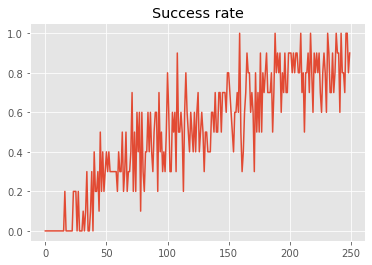

In [7]:
import gym
# from agent import Agent
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
# from play import Play
import mujoco_py
import random
from mpi4py import MPI
import psutil
import time
from copy import deepcopy as dc
import os
import torch

ENV_NAME = "FetchPickAndPlace-v1"
INTRO = False
Train = True
Play_FLAG = False
MAX_EPOCHS = 250
MAX_CYCLES = 50
num_updates = 40
MAX_EPISODES = 2
memory_size = 7e+5 // 50
batch_size = 256
actor_lr = 1e-3
critic_lr = 1e-3
gamma = 0.98
tau = 0.05
k_future = 4

test_env = gym.make(ENV_NAME)
state_shape = test_env.observation_space.spaces["observation"].shape
n_actions = test_env.action_space.shape[0]
n_goals = test_env.observation_space.spaces["desired_goal"].shape[0]
action_bounds = [test_env.action_space.low[0], test_env.action_space.high[0]]
to_gb = lambda in_bytes: in_bytes / 1024 / 1024 / 1024

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['IN_MPI'] = '1'


def eval_agent(env_, agent_):
    total_success_rate = []
    running_r = []
    for ep in range(10):
        per_success_rate = []
        env_dictionary = env_.reset()
        s = env_dictionary["observation"]
        ag = env_dictionary["achieved_goal"]
        g = env_dictionary["desired_goal"]
        while np.linalg.norm(ag - g) <= 0.05:
            env_dictionary = env_.reset()
            s = env_dictionary["observation"]
            ag = env_dictionary["achieved_goal"]
            g = env_dictionary["desired_goal"]
        ep_r = 0
        for t in range(50):
            with torch.no_grad():
                a = agent_.choose_action(s, g, train_mode=False)
            observation_new, r, _, info_ = env_.step(a)
            s = observation_new['observation']
            g = observation_new['desired_goal']
            per_success_rate.append(info_['is_success'])
            ep_r += r
        total_success_rate.append(per_success_rate)
        if ep == 0:
            running_r.append(ep_r)
        else:
            running_r.append(running_r[-1] * 0.99 + 0.01 * ep_r)
    total_success_rate = np.array(total_success_rate)
    local_success_rate = np.mean(total_success_rate[:, -1])
    global_success_rate = MPI.COMM_WORLD.allreduce(local_success_rate, op=MPI.SUM)
    return global_success_rate / MPI.COMM_WORLD.Get_size(), running_r, ep_r


if INTRO:
    print(f"state_shape:{state_shape[0]}\n"
          f"number of actions:{n_actions}\n"
          f"action boundaries:{action_bounds}\n"
          f"max timesteps:{test_env._max_episode_steps}")
    for _ in range(3):
        done = False
        test_env.reset()
        while not done:
            action = test_env.action_space.sample()
            test_state, test_reward, test_done, test_info = test_env.step(action)
            # substitute_goal = test_state["achieved_goal"].copy()
            # substitute_reward = test_env.compute_reward(
            #     test_state["achieved_goal"], substitute_goal, test_info)
            # print("r is {}, substitute_reward is {}".format(r, substitute_reward))
            test_env.render()
    exit(0)

env = gym.make(ENV_NAME)
env.seed(MPI.COMM_WORLD.Get_rank())
random.seed(MPI.COMM_WORLD.Get_rank())
np.random.seed(MPI.COMM_WORLD.Get_rank())
torch.manual_seed(MPI.COMM_WORLD.Get_rank())
agent = Agent(n_states=state_shape,
              n_actions=n_actions,
              n_goals=n_goals,
              action_bounds=action_bounds,
              capacity=memory_size,
              action_size=n_actions,
              batch_size=batch_size,
              actor_lr=actor_lr,
              critic_lr=critic_lr,
              gamma=gamma,
              tau=tau,
              k_future=k_future,
              env=dc(env))
if Train:

    t_success_rate = []
    total_ac_loss = []
    total_cr_loss = []
    for epoch in range(MAX_EPOCHS):
        start_time = time.time()
        epoch_actor_loss = 0
        epoch_critic_loss = 0
        for cycle in range(0, MAX_CYCLES):
            mb = []
            cycle_actor_loss = 0
            cycle_critic_loss = 0
            for episode in range(MAX_EPISODES):
                episode_dict = {
                    "state": [],
                    "action": [],
                    "info": [],
                    "achieved_goal": [],
                    "desired_goal": [],
                    "next_state": [],
                    "next_achieved_goal": []}
                env_dict = env.reset()
                state = env_dict["observation"]
                achieved_goal = env_dict["achieved_goal"]
                desired_goal = env_dict["desired_goal"]
                while np.linalg.norm(achieved_goal - desired_goal) <= 0.05:
                    env_dict = env.reset()
                    state = env_dict["observation"]
                    achieved_goal = env_dict["achieved_goal"]
                    desired_goal = env_dict["desired_goal"]
                for t in range(500):
                    action = agent.choose_action(state, desired_goal)
                    next_env_dict, reward, done, info = env.step(action)

                    next_state = next_env_dict["observation"]
                    next_achieved_goal = next_env_dict["achieved_goal"]
                    next_desired_goal = next_env_dict["desired_goal"]

                    episode_dict["state"].append(state.copy())
                    episode_dict["action"].append(action.copy())
                    episode_dict["achieved_goal"].append(achieved_goal.copy())
                    episode_dict["desired_goal"].append(desired_goal.copy())

                    state = next_state.copy()
                    achieved_goal = next_achieved_goal.copy()
                    desired_goal = next_desired_goal.copy()
                    
                    if done:
                        break

                episode_dict["state"].append(state.copy())
                episode_dict["achieved_goal"].append(achieved_goal.copy())
                episode_dict["desired_goal"].append(desired_goal.copy())
                episode_dict["next_state"] = episode_dict["state"][1:]
                episode_dict["next_achieved_goal"] = episode_dict["achieved_goal"][1:]
                mb.append(dc(episode_dict))

            agent.store(mb)
            for n_update in range(num_updates):
                actor_loss, critic_loss = agent.train()
                cycle_actor_loss += actor_loss
                cycle_critic_loss += critic_loss

            epoch_actor_loss += cycle_actor_loss / num_updates
            epoch_critic_loss += cycle_critic_loss /num_updates
            agent.update_networks()

        ram = psutil.virtual_memory()
        success_rate, running_reward, episode_reward = eval_agent(env, agent)
        total_ac_loss.append(epoch_actor_loss)
        total_cr_loss.append(epoch_critic_loss)
        if MPI.COMM_WORLD.Get_rank() == 0:
            t_success_rate.append(success_rate)
            print(f"Epoch:{epoch}| "
                  f"Running_reward:{running_reward[-1]:.3f}| "
                  f"EP_reward:{episode_reward:.3f}| "
                  f"Memory_length:{len(agent.memory)}| "
                  f"Duration:{time.time() - start_time:.3f}| "
                  f"Actor_Loss:{actor_loss:.3f}| "
                  f"Critic_Loss:{critic_loss:.3f}| "
                  f"Success rate:{success_rate:.3f}| "
                  f"{to_gb(ram.used):.1f}/{to_gb(ram.total):.1f} GB RAM")
            agent.save_weights()

    if MPI.COMM_WORLD.Get_rank() == 0:

        with SummaryWriter("logs") as writer:
            for i, success_rate in enumerate(t_success_rate):
                writer.add_scalar("Success_rate", success_rate, i)

        plt.style.use('ggplot')
        plt.figure()
        plt.plot(np.arange(0, MAX_EPOCHS), t_success_rate)
        plt.title("Success rate")
        plt.savefig("success_rate.png")
        plt.show()

elif Play_FLAG:
    player = Play(env, agent, max_episode=100)
    player.evaluate()

In [8]:
player = Play(env, agent, max_episode=100)
player.evaluate()

episode_reward:-8.000
episode_reward:-50.000
episode_reward:-8.000
episode_reward:-7.000
episode_reward:-10.000
episode_reward:-10.000
episode_reward:-47.000
episode_reward:-9.000
episode_reward:-6.000
episode_reward:-11.000
episode_reward:-50.000
episode_reward:-11.000
episode_reward:-10.000
episode_reward:-9.000
episode_reward:-9.000
episode_reward:-10.000
episode_reward:-12.000
episode_reward:-16.000
episode_reward:-8.000
episode_reward:-9.000
episode_reward:-50.000
episode_reward:-50.000
episode_reward:-11.000
episode_reward:-49.000
episode_reward:-6.000
episode_reward:-13.000
episode_reward:-11.000
episode_reward:-46.000
episode_reward:-9.000
episode_reward:-13.000
episode_reward:-7.000
episode_reward:-6.000
episode_reward:-48.000
episode_reward:-14.000
episode_reward:-8.000
episode_reward:-11.000
episode_reward:-11.000
episode_reward:-8.000
episode_reward:-10.000
episode_reward:-7.000
episode_reward:-7.000
episode_reward:-50.000
episode_reward:-9.000
episode_reward:-6.000
episode

## Lab Exercise

Use DDPG in two different OpenAI gym environments.
- Do not use FetchPickandPlace
- Write in the report what you did.
- Take the vdo and submit.